# Regression with Categorical Variables

## Setup

This time let's not run `setup.py` but make sure we run explicitely all the commands we need.

In [1]:
%matplotlib inline

In [2]:
# Import numpy package for numeric arrays and algebraic functions 
import numpy as np

#Creating plots
import matplotlib.pyplot as plt
import seaborn as sns

#Statistical packages
import sklearn.metrics as sk_metrics
from sklearn import datasets
import sklearn.linear_model as sk_lm
from scipy import stats

#Storing and manipulating data
import pandas as pd

#Some commands to make the plots look nice and big.
plt.rcParams['figure.figsize'] = (8,5)
plt.rcParams['figure.dpi'] = 120
plt.rcParams['lines.markersize'] = 7
plt.rcParams['lines.linewidth'] = 2

#Function returning the RMSE
def rmse(obs, pred, axis=1):
    return np.sqrt(sk_metrics.mean_squared_error(obs, pred))


---

## Example 1 - Book Weights

### 1.1 Books Data

This data set comes from the `DAAG` package in R and it gives the measurements on the volume (in cm$^3$) and weight (in g) of 15 books, some of which are softcover and some of which are hardback. Our goal with these data is to derive a model that allows us to predict the weight of a book give its volume and cover type.

These data have been stored as variables in the `books.py` file provided with this worksheet, we will load the data using `import`.

In [3]:
from books import volume, weight, cover

book_df = pd.DataFrame({'volume':volume, 'weight':weight, 'cover':cover}) 

n = len(volume)

As with any new data the first order of business is to plot them and visually examine them for any potential relationship. 

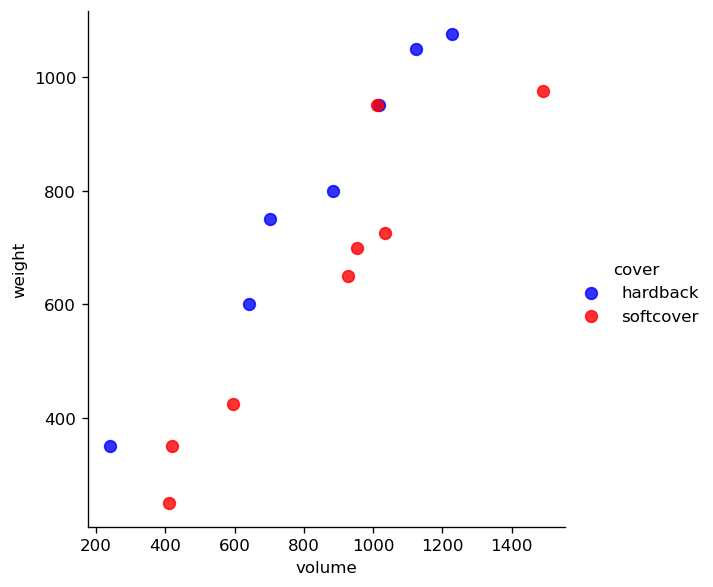

In [4]:
#Scatterplot with datapoints coloured by cover-type
sns.lmplot('volume', 'weight', data=book_df, hue='cover', fit_reg=False, palette=['b','r']) 
plt.show()

---

### &diams; Exercise 1.1

Based on the scatter plot above, how would you describe the relationship between the weight of the books and their volume? Does the cover type seem to play a role in this relationship?


**Solution** 

There appears to be an increasing linear relationship between volume and weight, hardback books look like they weigh more than softcover books for an equivalent volume.

---

We will now fit a linear regression model to these data and see what it tells us about their relationship(s). As before we will be using `sklearn`s `LinearRegression` function to fit the model and obtain our estimates for $\beta_0$ and $\beta_1$.

In [5]:
# Create a linear regression object we will use to fit our models 
# Note that we have set fit_intercept to False, so we will need to 
# provide the column of ones if we want an intercept coefficient.

linear_model = sk_lm.LinearRegression(fit_intercept=False)

In [6]:
X = np.c_[np.ones(n), volume]     # Construct the model matrix by concatenating (putting together) an array of ones and a data array
reg = linear_model.fit(X, weight) # Fit the linear model

b0, b1 = reg.coef_                # Extract the coefficients (betas)

print((b0,b1))

(107.67931061376645, 0.7086371433704163)


In [7]:
y_hat = reg.predict(X)                      # Predict weight for observed volumes

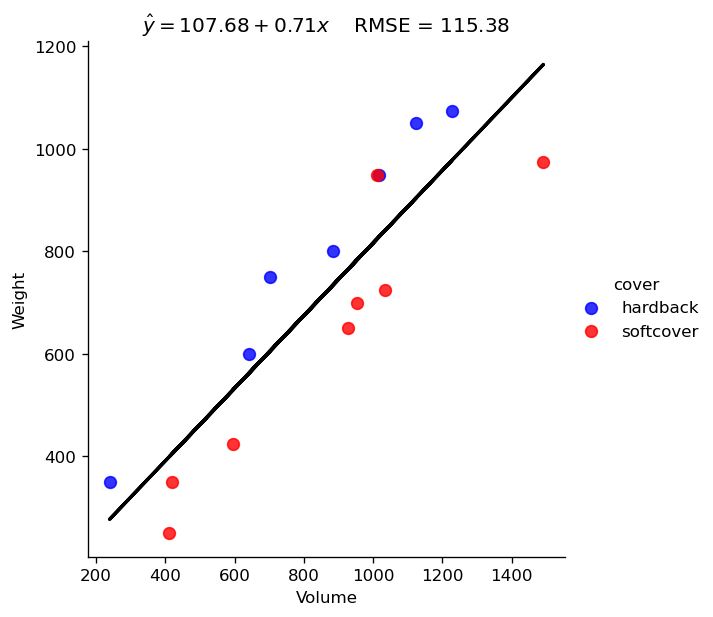

In [8]:
sns.lmplot('volume', 'weight', data=book_df, hue='cover', fit_reg=False, palette=['b','r'])  #Scatterplot with datapoints coloured by cover-type

plt.plot(volume, y_hat, "k-") # Add regression line to scatter plot
plt.xlabel("Volume")
plt.ylabel("Weight")
plt.title("$\hat{y} = %.2f + %.2f x$    RMSE = %.2f" % (b0, b1, rmse(weight, y_hat)))
plt.show()

---

### &diams; Exercise 1.2

As mentioned last time, a residual is the difference between the observed and predicted value, $y_i - \hat{y}_i$. Create a scatter plot of the residuals vs fitted values, based on that plot what can you say about the residuals of the hardback books vs the softcover books? What does this observation tell us about potential weaknesses of our model?


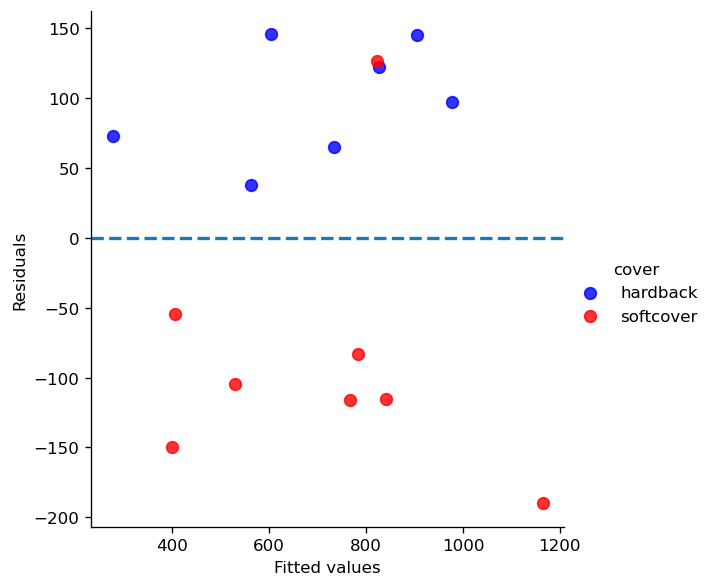

In [9]:
book_df['fitted'] = y_hat
book_df['residuals'] = book_df['weight'] - y_hat

sns.lmplot('fitted', 'residuals', data=book_df, hue='cover', fit_reg=False, palette=['b','r'])  

plt.axhline(y=0,ls="--") 
plt.xlabel("Fitted values")
plt.ylabel("Residuals")
plt.show()

All of the hardback books have positive residuals while all but one of the softcover books have negative residuals. Our model is consistently underestimating hardcover book weights and overestimating softcover book weights.

---

### 1.2 Dummy Coding

Based on these results, it should be clear that it is important that our model include information about whether or not a book is a hardback or softcover. As such, we need a way of encoding this information into our modeling framework. To do this we need a way of turning our text / categorical variable into a numeric representation that can be included in our model matrix.

The most common approach for doing this is called dummy coding, in the case of a binary catergorical variable it involves picking one of the two levels of the categorical variable and encoding it as 1 and the other level as 0. With Python we can accomplish this by comparing our categorical vector to the value of our choice and then casting (converting) the result to an integer type.

For example if we wanted to code `hardback` as 1 and `softcover` as 0 we would do the following,

In [10]:
hardback = (cover == "hardback").astype(int) # Returns either 0 or 1
hardback

array([1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0])

This is equivalent to using an indicator function in mathematical notation,

$$ 
\mathbb{1}_{hb_i} = 
\begin{cases}
1 & \text {if cover of book $i$ is hardback} \\
0 & \text {if cover of book $i$ is softcover}
\end{cases}
$$

Alternatively, we can defined the opposite of this where we code `hardback` as 0 and `softcover` as 1,


In [11]:
softcover = (cover == "softcover").astype(int)
softcover

array([0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1])

Now that we have recoded our categorical variable, `cover`, into a numerical variable we can fit a standard regression model with the form,

$$ y_i = \beta_0 + \beta_1 \, x_i + \beta_2 \, \mathbb{1}_{hb_i} $$

which we can represent in matrix form using,
$$\boldsymbol{y} = \boldsymbol{X} \boldsymbol{\beta}$$  
where 
$$\boldsymbol{X} = \big[ \boldsymbol{1},\, \boldsymbol{x},\, \boldsymbol{\mathbb{1}_{hb}} \big]$$.

Using Python, we can use the usual concatenate function with our 1s column, the volume column, and our new dummy coded indicator column.

In [12]:
X = np.c_[np.ones(n), volume, hardback]
reg = linear_model.fit(X, weight)

b0, b1, b2 = reg.coef_
print((b0,b1,b2))

(13.915572191126039, 0.7179537437859397, 184.04727138159208)


This gives us a regression equation of the form,

$$ 
y_i = 13.9 + 0.72 \, x_i + 184.0 \, \mathbb{1}_{hb_i} 
$$

which can be rewritten as two separate line equations (one for each case of `cover`),

$$
y_i = \begin{cases}
        13.9 + 0.72 \, x_i & \text{if book cover $i$ is hardback} \\
        (13.9 + 184.0) + 0.72 \, x_i & \text{if book cover $i$ is softcover} \\
       \end{cases}.
$$

We can calculate prediction points along those lines using the following Python code in which we hard code the possible values of $\boldsymbol{\mathbb{1}_{hb_i}}$

In [13]:
y_hat = reg.predict(X)              # Predict weights for the observed volumes

sc = b0 + b1 * volume + b2 * 0 # prediction volumes for softcover books
hb = b0 + b1 * volume + b2 * 1 # prediction volumes for hardback books

We can then plot both of these lines along with the observed data.

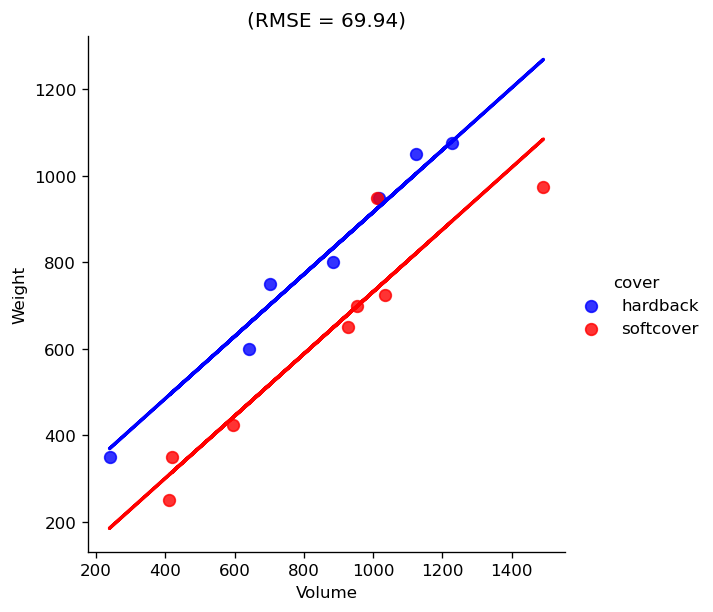

In [14]:
sns.lmplot('volume', 'weight', data=book_df, hue='cover', fit_reg=False, palette=['b','r'])
plt.plot(volume, hb, 'b-')  # Add hardback regression line
plt.plot(volume, sc, 'r-') # Add softcover regression line
plt.title("(RMSE = %.2f)" % rmse(weight, y_hat))
plt.xlabel("Volume")
plt.ylabel("Weight")
plt.show()

---

### &diams; Exercise 1.3

Based on these regression fits, do you think the model including the dummy coded `cover` variable produces a "better" model than our first regression model which did not include `cover`? Explain. 

**Solution**

This model appears to fit the data better, both by visual inspection as well as the greatly improved RMSE.

---

Note that by including a dummy variable in our model we must also change the interpretation of our regression coefficients. In this context,

* $\beta_0$ - This is the expected weight of a book with a `volume` of zero and a `hardback` indicator of zero, in other words a softcover book with zero volume.

* $\beta_1$ - This is the expected additional weight a book would have if its volume were to increase by 1 cm$^3$, all else being equal.

* $\beta_2$ - This is the expected additional weight a book would have if its hardcover indicator were to increase by 1, all else being equal. However, the hardcover indicator can only be 0 or 1 and hence this is the change in weight we would expect between a softcover book and a hardcover book with the same volume. In other words, hardcover books weight 184g more than softcover books.

Based on these interpretations we can see that the level that was coded as 0 (what is often called the reference level) gets folded into our intercept. The slope coefficient for the indicator provides the difference in intercept between the reference and the contrast level (level coded as 1).


---

### &diams; Exercise 1.4

Repeat the analysis above but this time fit a model using `softcover` instead of `hardcover` in your model matrix. You should fit the new model as well as calculate the predictions for both softcover and hardback books. Finally, create a scatter plot of the data along with the model fit. 

**Solution**

(197.9628435727181, 0.7179537437859432, -184.04727138159188)


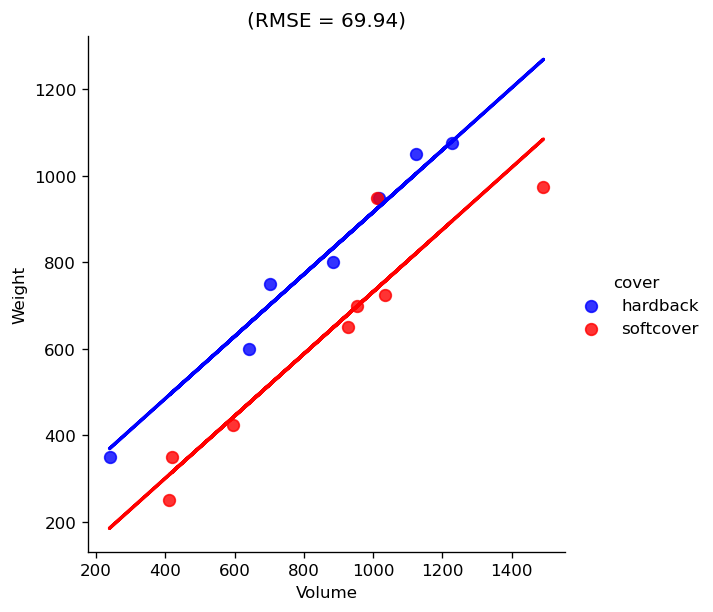

In [15]:
X = np.c_[np.ones(n), volume, softcover]
reg = linear_model.fit(X, weight)

b0, b1, b2 = reg.coef_
print((b0,b1,b2))

y_hat = reg.predict(X)

sc = b0 + b1 * volume + b2 * 1
hb = b0 + b1 * volume + b2 * 0 

sns.lmplot('volume', 'weight', data=book_df, hue='cover', fit_reg=False, palette=['b','r'])
plt.plot(volume, hb, 'b-')  # Add hardback regression line
plt.plot(volume, sc, 'r-') # Add softcover regression line
plt.title("(RMSE = %.2f)" % rmse(weight, y_hat))
plt.xlabel("Volume")
plt.ylabel("Weight")
plt.show()

---

### &diams; Exercise 1.4

What changed between the model with `softcover` vs the model with `hardcover`? Specifically, comment on the values of $\beta_0$, $\beta_1$, and $\beta_2$ and their interpretations.


**Solution**

The new $\beta_0 = 198.9$ is equal to the previous $\beta_0+\beta_2 = 13.9 + 184$. $\beta_1$ has not changed.

$\beta_0$ is now the expected weight of a hardback book with 0 volume, while $\beta_2$ is the difference in expected weight of a softcover vs hardback book with 0 volume.

---

Now lets consider the model where we naievely include both `hardback` and `softcover` as predictors in our model.

In [16]:
X = np.c_[np.ones(n), volume, hardback, softcover]
reg = linear_model.fit(X, weight)

b0, b1, b2, b3 = reg.coef_
print( (b0, b1, b2, b3) )

(70.62613858794802, 0.7179537437859418, 127.33670498477, -56.71056639682191)


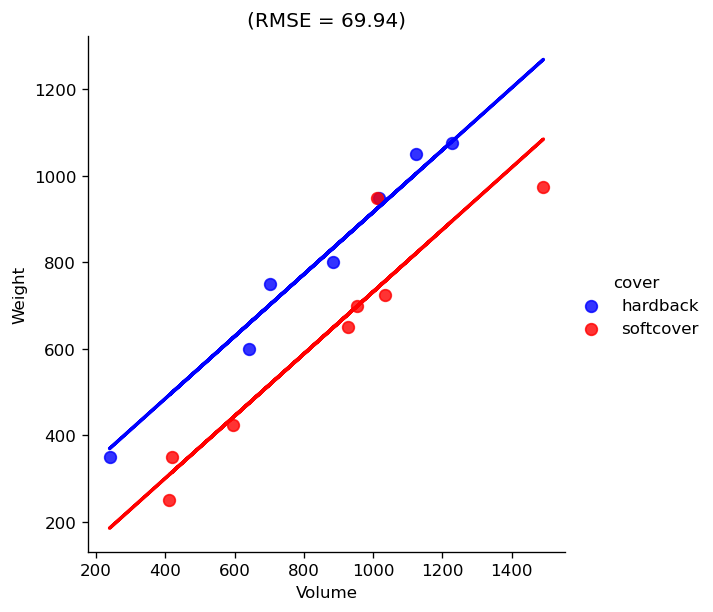

In [17]:
y_hat = reg.predict(X)

hb = b0 + b1 * volume + b2 * 1 + b3 * 0
sc = b0 + b1 * volume + b2 * 0 + b3 * 1

sns.lmplot('volume', 'weight', data=book_df, hue='cover', fit_reg=False, palette=['b','r'])
plt.plot(volume, hb, 'b-')  # Add hardback regression line
plt.plot(volume, sc, 'r-') # Add softcover regression line
plt.title("(RMSE = %.2f)" % rmse(weight, y_hat))
plt.xlabel("Volume")
plt.ylabel("Weight")
plt.show()

---

### &diams; Exercise 1.5

Write out the equations that predict weight for hardback and softcover books according to this model.  


$$
\begin{aligned}
y_i &= 
\begin{cases}
    70.6 + 0.72 \, x_i + 127.3 \times 1 -56.7 \times 0 & \text{if book cover $i$ is hardback} \\
    70.6 + 0.72 \, x_i + 127.3 \times 0 -56.7 \times 1 & \text{if book cover $i$ is softcover} \\
\end{cases} \\
&= 
\begin{cases}
    197.9 + 0.72 \, x_i & \text{if book cover $i$ is hardback} \\
    13.9 + 0.72 \, x_i  & \text{if book cover $i$ is softcover} \\
\end{cases} \\  
\end{aligned}
$$

---

### &diams; Exercise 1.6

Are the solutions given above unique? Can you find different values of $\beta_0$, $\beta_1$, $\beta_2$, and $\beta_3$ that would give you the same regression equations you wrote out in **Exercise 4**?

**Solution**

These solutions are not unique, $\beta_1$ will cannot change but any solution where $\beta_0+\beta_2 = 197.9$ and $\beta_0+\beta3 = 13.9$ will work. 

For example $\beta_0 = 0$, $\beta_2 = 197.9$, and $\beta_3 = 13.9$ will give the same regression lines. This example is equivalent to not fitting an intercept, a method which is popular in machine learning and referred to as "one hot coding". 

---

##  Case study - continued


For this last section we will pretend that you have been in touch with the owner of previous weeks dataset, containing life expectancy data (1) from different countries around the world, to enquire about the BMI values. In reply he has sent you an updated version of the dataset which no longer contains data on BMI but contains a few new variables, along with the following data dictionary.

(1) Modified from: Kumar Rajarshi. (Feb 2018). Life Expecancy (WHO), 1. https://www.kaggle.com/kumarajarshi/life-expectancy-who.

|**Data dictionary:**|                                                                                          |
|--------------------|------------------------------------------------------------------------------------------|
|life_exp | Life expectancy in age |
|Alcohol | Alcohol, recorded per capita (15+) consumption (in litres of pure alcohol) |
|tot_exp | General government expenditure on health as a percentage of total government expenditure (%)|
|GDP | Gross Domestic Product per capita (in USD)|
|Population | Population of the country|
|thinness1_19y | Prevalence of thinness among children and adolescents for Age 10 to 19 (% )|
|thinness5_9y | Prevalence of thinness among children for Age 5 to 9 (% )|
|Schooling | Number of years of Schooling(years)| 
|developing | Binary indicator of developing countries|
|hepB | Hepatitis B (HepB) immunization coverage among 1-year-olds (%), 'H' >= 95%, 'M' [80,95[%, 'L' < 80%|
|polio | Polio immunization coverage among 1-year-olds (%), 'H' >= 95%, 'M' [80,95[%, 'L' < 80%|
|dipt | Diphtheria tetanus toxoid and pertussis (DTP3) immunization coverage among 1-year-olds (%), 'H' >= 95%, 'M' [80,95[%, 'L' < 80%|                                                                                               

---

Our first step, is always to  read in the data and look at it.

In [18]:
df_life = pd.read_csv('life_xp2.csv', index_col=0) # Read the data into a dataframe,
                                                   # index_col=0 removes the first column of indexes,
                                                   # you can run this block without it to see for yourself what it does. 

df_life.describe(include='all')   # Description of the data columns.
# All columns have a count = number of non-missing entries.
# Categorical variables show the "unique" values, the "top" value, and its frequency "freq".
# Continuous variables, mean, std, min, max and quantiles 0.25, 0.50 and 0.75. 
# You will already be familiar with quantile 0.50 as the median 
# i.e. if you order your data by increasing value, 50% will be smaller than quantile 0.50 and 50% larger. 
# Similarly, at quantile 0.25, 25% will be smaller than quantile 0.25 and 75% larger.

,life_exp,Alcohol,tot_exp,GDP,Population,thinness1_19y,thinness5_9y,Schooling,developing,hepB,polio,dipt
count,2455.000000,2456.000000,2435.000000,2099.000000,1.923000e+03,2444.000000,2444.000000,2327.000000,2456.000000,1956,2265,2270
unique,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3,3,3
top,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,H,H,H
freq,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,755,1046,1026
mean,69.515031,5.141437,5.999125,7937.177729,1.326445e+07,4.650409,4.671686,12.120756,0.805782,NaN,NaN,NaN
std,9.692522,3.947626,2.482979,14910.682597,6.543087e+07,4.335700,4.429002,3.269978,0.395678,NaN,NaN,NaN
min,36.300000,0.020000,0.370000,1.681350,3.400000e+01,0.100000,0.100000,0.000000,0.000000,NaN,NaN,NaN
25%,63.800000,1.600000,4.330000,462.318087,1.921045e+05,1.500000,1.500000,10.200000,1.000000,NaN,NaN,NaN
50%,72.500000,4.360000,5.820000,1882.278420,1.396861e+06,3.100000,3.100000,12.400000,1.000000,NaN,NaN,NaN
75%,76.000000,8.250000,7.555000,6381.984217,7.403584e+06,7.000000,7.000000,14.300000,1.000000,NaN,NaN,NaN


---

### &diams; Exercise 2.1

Look at the data description above and share any first thoughts.

**Solution**

* Less than 25% are classed as "developing". Is there a problem with this data or is most of the data truly coming from developing countries? 
* There are missing values, especially in the vaccination variables. 
* The two thinness variables seem quite similar. Also it seems likely that countries that have a scarcity of food for 5-9 year olds would also lack food for 10-19 year olds and vice versa.

---

### &diams; Exercise 2.2

Have a look at the correlations between the continuous variables. Are any of the explanatory variables strongly correlated with each other? What do the correlations between life expectancy and the explanatory variables indicate?

In [19]:
cat_vars = ['developing','hepB','polio','dipt']

df_life.loc[:,~df_life.columns.isin(cat_vars)].corr() #.loc[rows to use (a), columns to use (b)]
                                                      # (a) : - ALL
                                                      # (b) ~ - NOT the columns in cat_vars
                                                      # .corr() function with correlation between the dataframe variables as output

,life_exp,Alcohol,tot_exp,GDP,Population,thinness1_19y,thinness5_9y,Schooling
life_exp,1.000000,0.409653,0.240620,0.461346,-0.025517,-0.497900,-0.490721,0.762337
Alcohol,0.409653,1.000000,0.309400,0.357364,-0.044958,-0.440605,-0.425355,0.579038
tot_exp,0.240620,0.309400,1.000000,0.160497,-0.077795,-0.297720,-0.299641,0.292216
GDP,0.461346,0.357364,0.160497,1.000000,-0.031510,-0.293680,-0.297298,0.454993
Population,-0.025517,-0.044958,-0.077795,-0.031510,1.000000,0.271952,0.270322,-0.034383
thinness1_19y,-0.497900,-0.440605,-0.297720,-0.293680,0.271952,1.000000,0.955953,-0.489116
thinness5_9y,-0.490721,-0.425355,-0.299641,-0.297298,0.270322,0.955953,1.000000,-0.473621
Schooling,0.762337,0.579038,0.292216,0.454993,-0.034383,-0.489116,-0.473621,1.000000


**Solution**

* The two thinness variables are very strongly correlated as expected. To avoid misleading results only one of them ought to be included in the model. *Hint: you can greatly reduce the number of variables in the EOT by examining correlated variables.*
* There is an indication of some linear relationship between all explanatory variables, except for 'Population', and life expectancy.     
---

### &diams; Exercise 2.3

Plot and inspect the continuous explanatory variables.

**Solution**

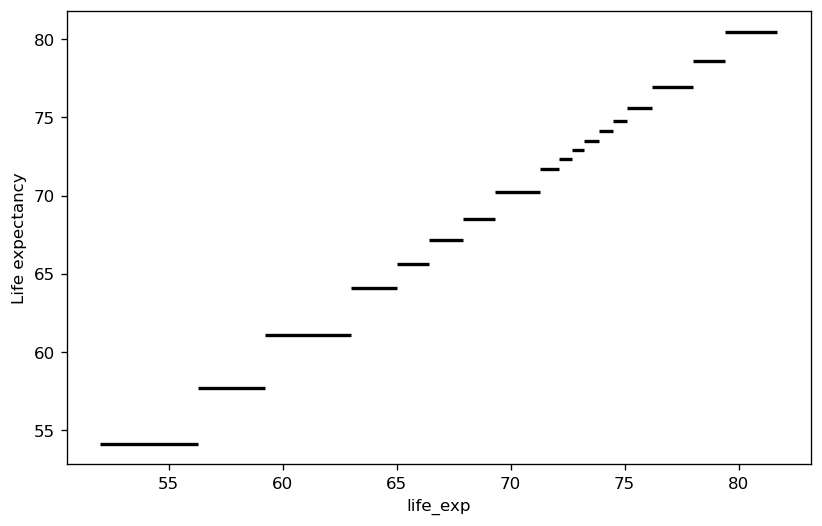

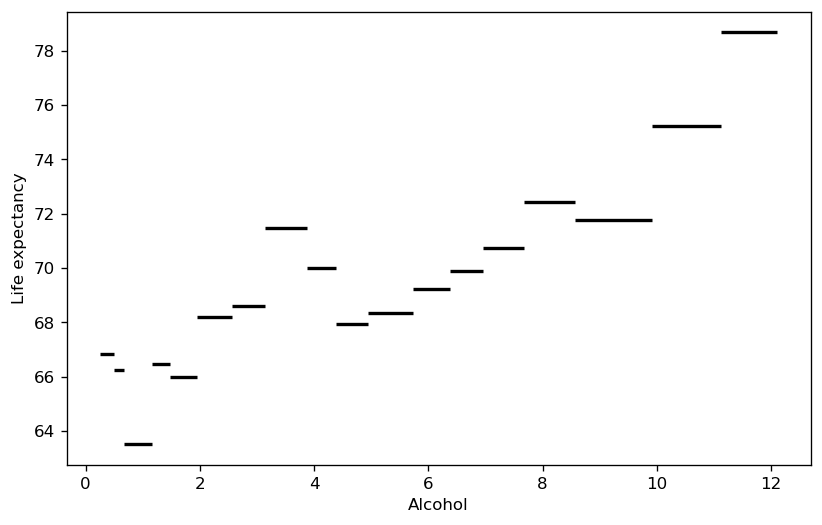

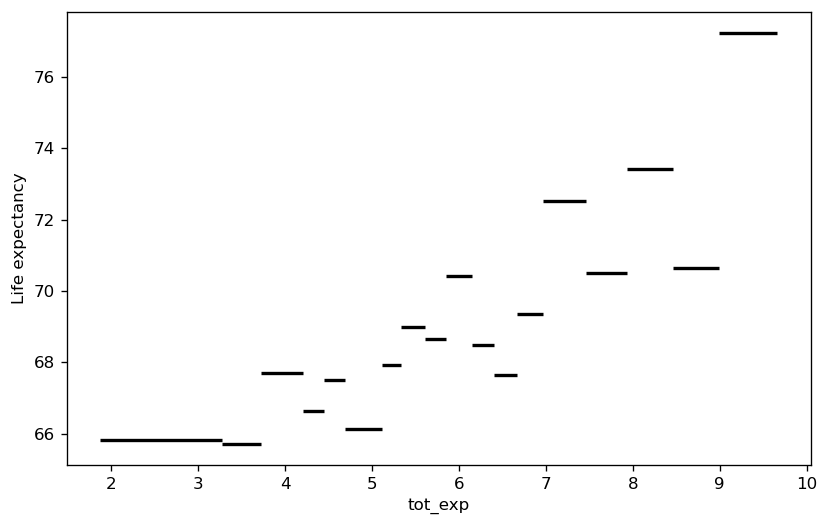

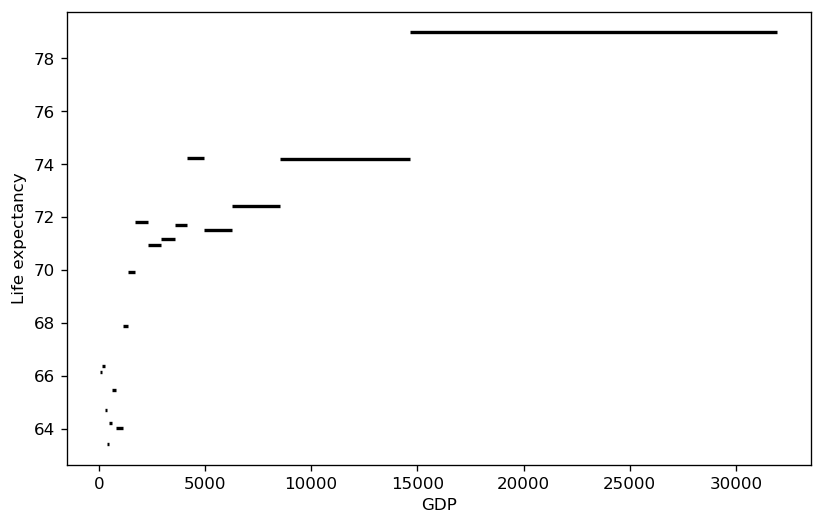

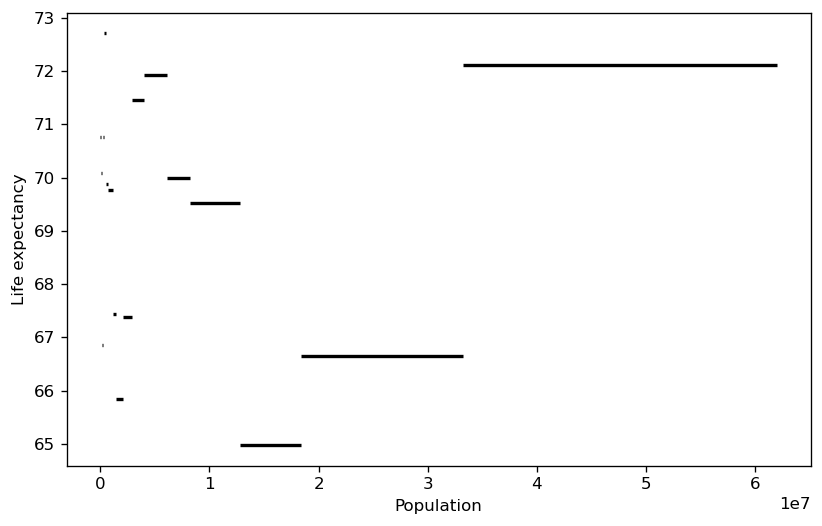

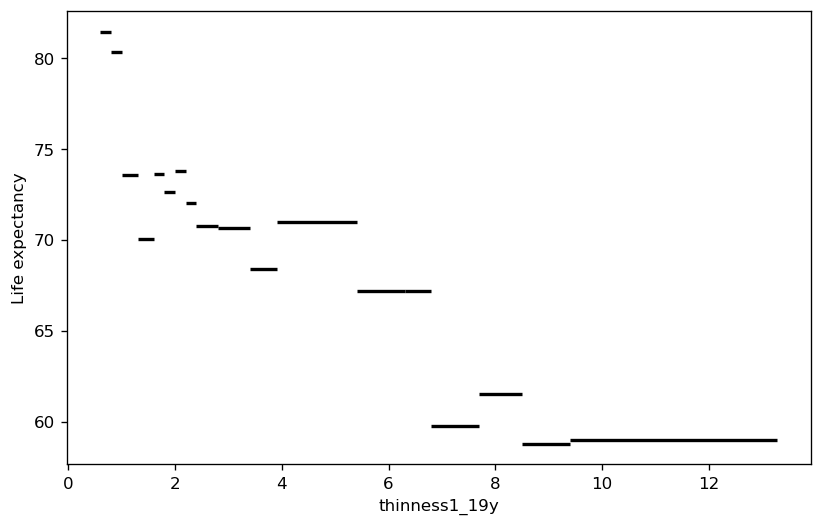

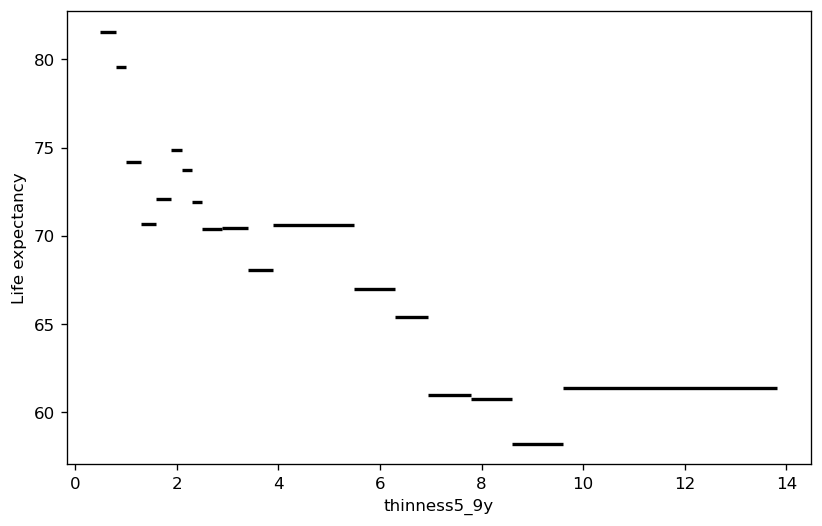

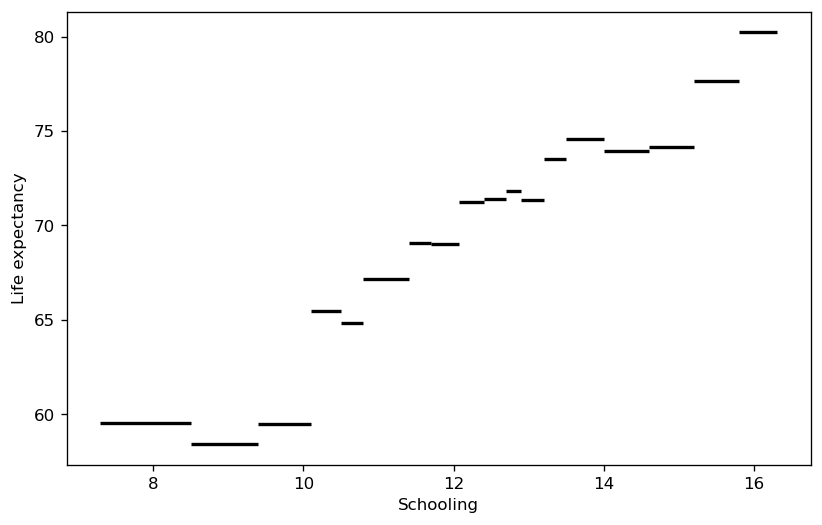

life_exp         None
Alcohol          None
tot_exp          None
GDP              None
Population       None
thinness1_19y    None
thinness5_9y     None
Schooling        None
dtype: object

In [20]:
df_life.dropna(inplace = True)

#Function taking the mean of 
def binned_stats(var):
    bin_means, bin_edges, binnumber = stats.binned_statistic(var,
                       df_life.life_exp,
                       statistic='mean', 
                       bins=np.quantile(var,np.arange(0.05,1,0.05)))
    plt.hlines(bin_means, bin_edges[:-1], bin_edges[1:])
    plt.xlabel(var.name)
    plt.ylabel('Life expectancy')
    plt.show()

df_life.loc[:,~df_life.columns.isin(cat_vars)].apply(binned_stats,axis=0)

From the above figures it appears reasonable to include in the model:
* A linear relationship with Alcohol and log(GDP) - based on last week's tutorial.
* With the additional datapoints it appears the the cubic relationship we fitted last week for 'Schooling' may have been an overfit and a linear one might be more appropriate.
* A quadraric (or any other suitably justified relationship) appears appropriate for tot_exp and one of the thinness variables.
* The relationship with thinness5_9y appears slightly better defined (this is subjective and any reasonable justification for using either thinness variable is good).
---

Now let's inspect the categorical variables using boxplots. 

Boxplots are a visual equivalent of the table we obtained with the .describe() function. The bottomline of the box is the 25th quantile, the midlle one the median, and the top line the 75th quantile. The bars represent minimum and maximum values (excepting outliers - please refer to the seaborn documentation for more information). 

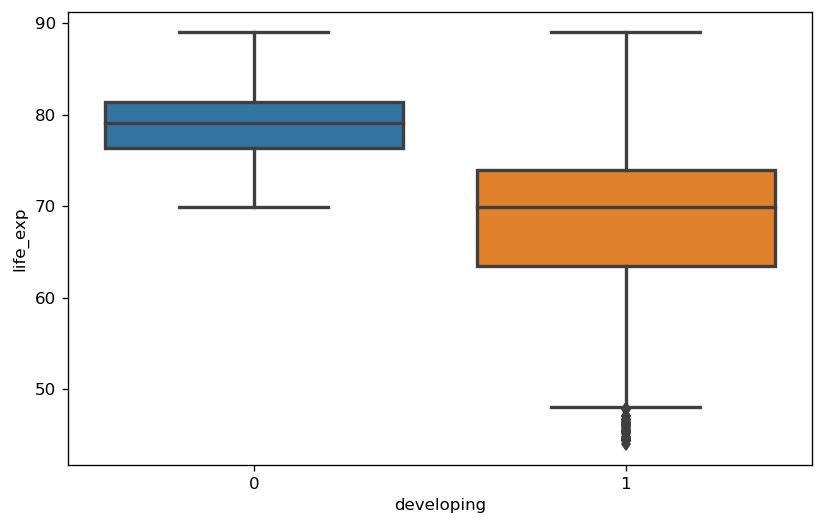

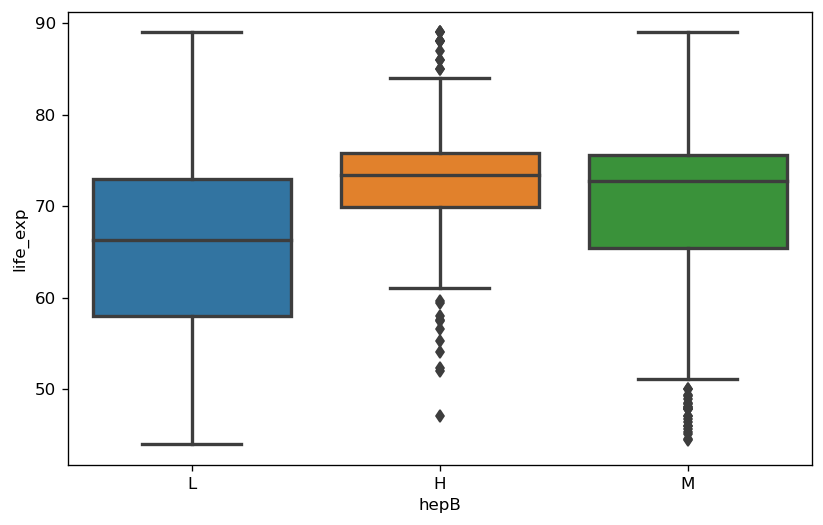

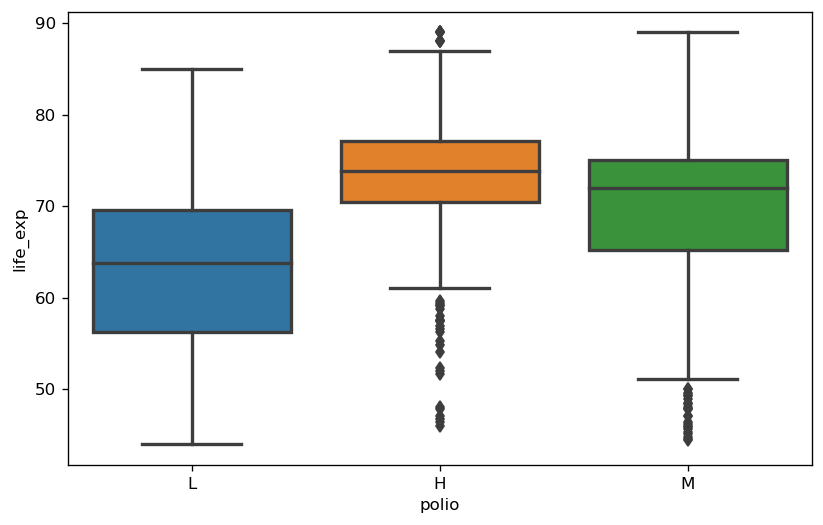

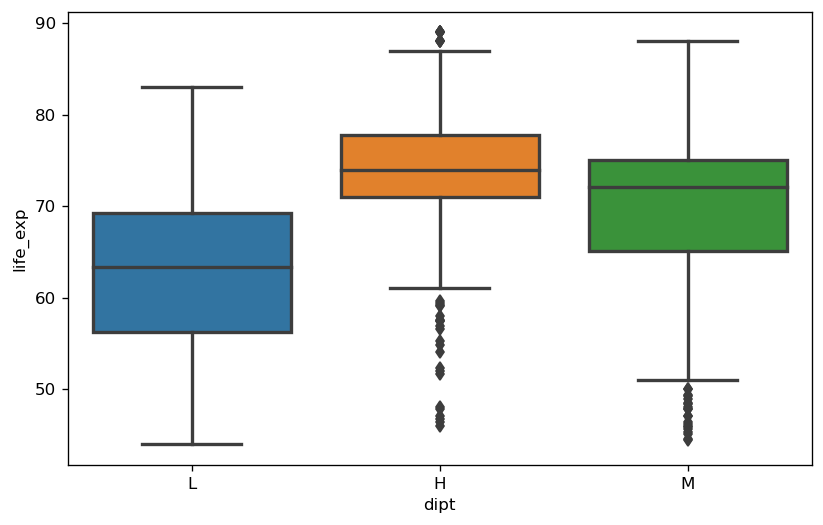

In [21]:
for var in df_life.loc[:,cat_vars]:
    plt.figure()
    sns.boxplot(x=var, y="life_exp", data=df_life) 

---
### &diams; Exercise 2.4

Based on the above boxplots, is there any support for including any of the categorical variables in the model?

**Solution**

Yes, the distribution of life expectancy appears to differ for the different levels of each of the categorical variables.

---
### &diams; Exercise 2.5

Based on your conclusions from exercises 2.3 and 2.4 use LaTex to write down an expression summarising the relationship between life expectancy and the chosen explanatory variables. 

**Solution**

$$\mathbf{\hat{y}} = \begin{pmatrix} \mathbf{1}\\
                                 \text{Alcohol} \\
                                 \text{Schooling} \\
                                 \text{log(GDP)}\\
                                 \text{Health expenditure}\\
                                 (\text{Health expenditure})^2\\
                                 \text{Thinness 5-9 y.o.}\\
                                 (\text{Thinness 5-9 y.o.})^2\\
                                 \text{Developing}\\
                                 \text{hepB}\\
                                 \text{Polio}\\
                                 \text{Diphtheria} \end{pmatrix}^T \mathbf{\beta}$$
                                 

---
### &diams; Exercise 2.6

Create an indicator array for each level of the three vaccines as in part 1.2 above. 

**Solution**

In [22]:
df_life['hepB_H'] = (df_life.hepB == "H").astype(int)
df_life['hepB_M'] = (df_life.hepB == "M").astype(int)
df_life['hepB_L'] = (df_life.hepB == "L").astype(int)

df_life['polio_H'] = (df_life.polio == "H").astype(int)
df_life['polio_M'] = (df_life.polio == "M").astype(int)
df_life['polio_L'] = (df_life.polio == "L").astype(int)

df_life['dipt_H'] = (df_life.dipt == "H").astype(int)
df_life['dipt_M'] = (df_life.dipt == "M").astype(int)
df_life['dipt_L'] = (df_life.dipt == "L").astype(int)

---
### &diams; Exercise 2.7

Using the expression in 2.5 as reference and the indicator variables from 2.6 build the matrix of explanatory variables $\mathbf{X}$, fit the linear regression and plot the residuals and observed vs fits. 

**Solution**

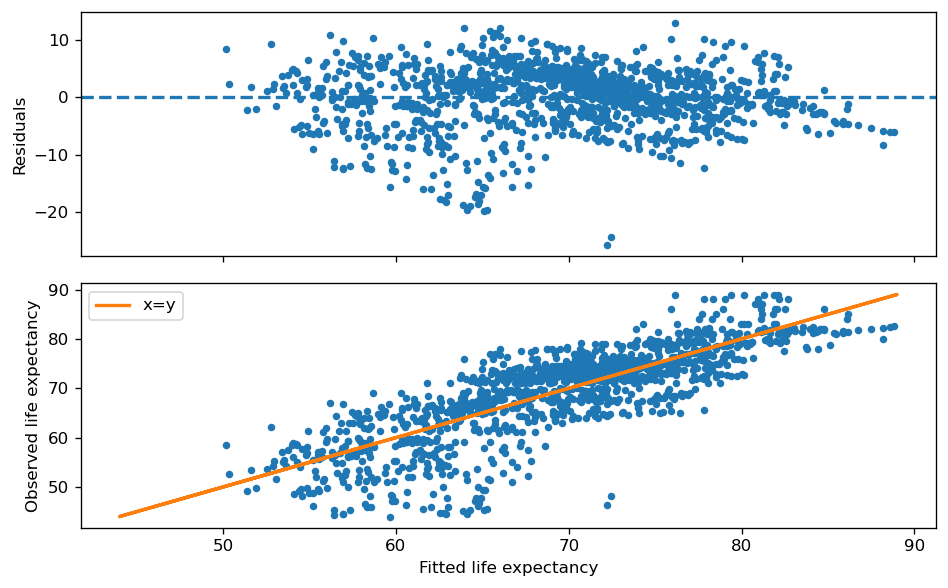

In [23]:
df2 = df_life.copy() #Make a copy of the dataframe
df2['log_gdp'] = np.log(df2.GDP) # create log-scale GDP column
df2.drop(columns=['life_exp','Population','thinness1_19y','hepB','polio','dipt','GDP'],axis=0,inplace=True) 
#Remove the columns we don't want, axis=0 - columns, inplace - delete from itself and don't return anything.

n = len(df_life.life_exp)
X = np.c_[np.ones(n), df2, df2.tot_exp**2, df2.thinness5_9y**2] 

#Regression
reg = linear_model.fit(X, df_life.life_exp)
fitted_lifexp = reg.predict(X)
residuals = df_life.life_exp - fitted_lifexp

#Plot residuals and observed data vs fits 
f, (ax1, ax2) = plt.subplots(2, 1, sharex = True)
ax1.plot(fitted_lifexp, residuals,'.')
ax1.set_ylabel("Residuals")
ax1.axhline(y=0, ls='--')

ax2.plot(fitted_lifexp, df_life.life_exp,'.')
ax2.plot(df_life.life_exp, df_life.life_exp,'-',label='x=y')
ax2.set_ylabel("Observed life expectancy")
ax2.set_xlabel("Fitted life expectancy")
ax2.legend()

plt.tight_layout()

---

### &diams; Exercise 4.4

Based on the above plots, does our model appear reasonable? Justify your answers.

**Solution**

The model seems to slightly overestimate the data towards the lower and higher end but other than that the residuals are relatively evenly spread around 0 and the observed vs fits are relatively tightly spread around the identity line.

---

### &diams; Exercise 4.5

Print the coefficients and the RMSE  and discuss what you observe.

In [24]:
#Print outputs
coef_names = df2.columns.tolist()
coef_names.extend(['tot_exp^2','thinness5_9y^2'])
coef_names.insert(0,'Intercept')
print(np.c_[coef_names,reg.coef_])
print(r'RMSE {:.3f}'.format(rmse(df_life.life_exp,fitted_lifexp)))

[['Intercept' '27.632087954079445']
 ['Alcohol' '-0.581944263200404']
 ['tot_exp' '-0.3964844222870264']
 ['thinness5_9y' '-1.3048098680834364']
 ['Schooling' '1.6473087381251765']
 ['developing' '-2.997437757244415']
 ['hepB_H' '9.57251910684677']
 ['hepB_M' '8.764576615799747']
 ['hepB_L' '9.294992231432945']
 ['polio_H' '9.404761437346671']
 ['polio_M' '10.07787196517242']
 ['polio_L' '8.14945455156035']
 ['dipt_H' '10.658271805414108']
 ['dipt_M' '9.608905631863818']
 ['dipt_L' '7.364910516801512']
 ['log_gdp' '0.6628115345596036']
 ['tot_exp^2' '0.021943721380367005']
 ['thinness5_9y^2' '0.04832410710096452']]
RMSE 5.178


* The RMSE is slightly improved compared to last week.
* The intercept is much lower than last week but returns to a similar value once we add a level for each of the three vaccines.
* Alcohol has a slightly stronger negative relationship.